In [37]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tabulate

# Setup plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Connect to DuckDB (In-memory mode)
con = duckdb.connect()

# Point to the the Parquet file as a table/view (no load implied)
# Now we can query as if it was a table in a DB 
con.execute(
    "CREATE OR REPLACE VIEW gold_data AS SELECT * FROM '../data/gold/daily_stats.parquet'"
)

# Sanity Check
print("Total Rows:", con.execute("SELECT COUNT(*) FROM gold_data").fetchone()[0])

# con.execute("DESCRIBE gold_data").df()

Total Rows: 221594


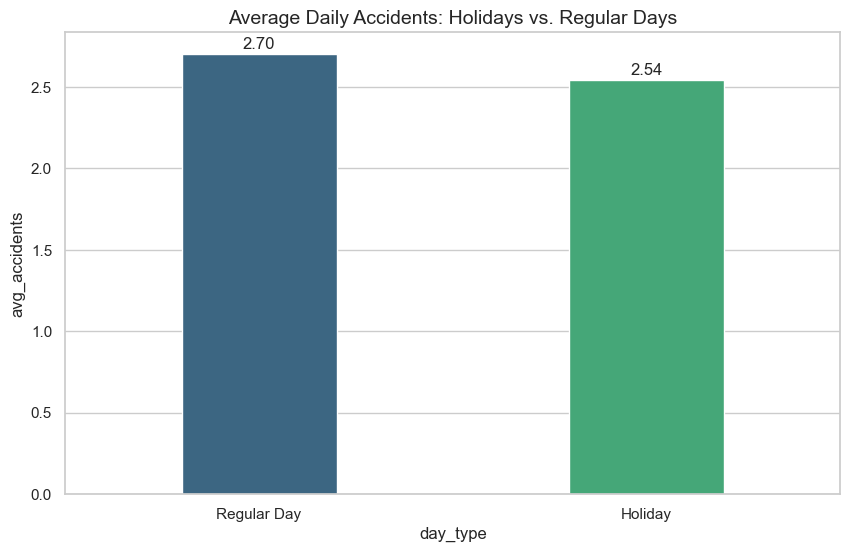

In [38]:
sql_holiday = """
    SELECT 
        CASE 
            WHEN holiday_name != 'Non-Holiday' THEN 'Holiday'
            ELSE 'Regular Day' 
        END AS day_type,
        AVG(total_accidents) AS avg_accidents,
        AVG(number_of_persons_injured) AS avg_injuries
    FROM gold_data
    GROUP BY day_type
"""

# DuckDB to execute the SQL and Pandas DataFrame for plotting later
df_holiday = con.execute(sql_holiday).fetchdf()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=df_holiday,
    x='day_type',
    y='avg_accidents',
    hue='day_type',
    legend=False,
    palette='viridis',
    width=0.4,
    dodge=False,
    ax=ax1
)
ax1.set_title("Average Daily Accidents: Holidays vs. Regular Days", fontsize=14)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=2)
    
plt.show()

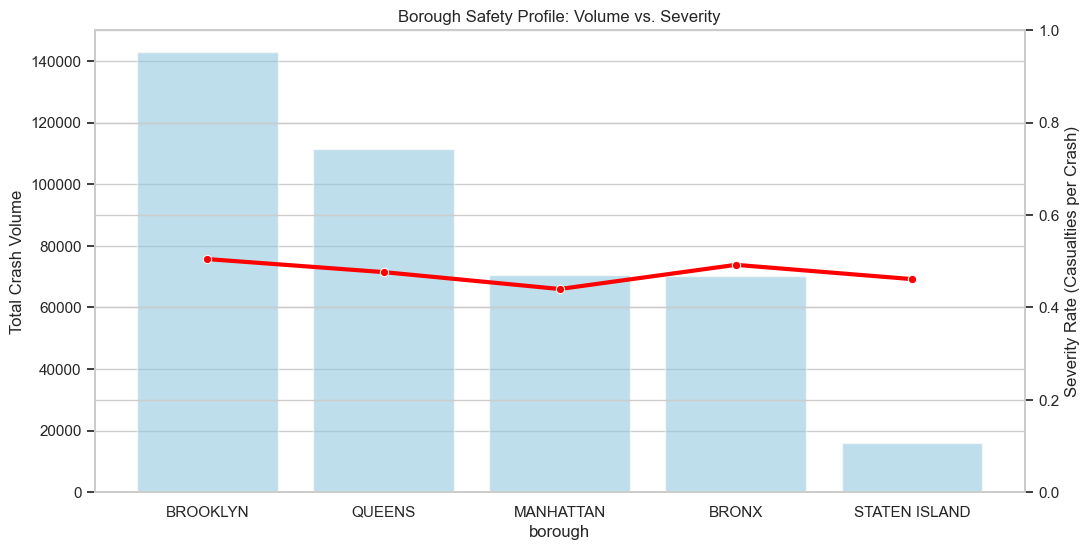

In [39]:
sql_borough = """
    SELECT 
        borough,
        SUM(total_accidents) AS total_crashes,
        -- Calculate Severity: (Injured + Killed) / Total Crashes
        (SUM(number_of_persons_injured) + SUM(number_of_persons_killed)) / CAST(SUM(total_accidents) AS FLOAT) AS severity_rate
    FROM gold_data
    WHERE borough != 'UNKNOWN'
    GROUP BY borough
    ORDER BY total_crashes DESC
"""

df_borough = con.execute(sql_borough).fetchdf()

# Visualization (Dual Axis)
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=df_borough, x='borough', y='total_crashes', color='skyblue', ax=ax1, alpha=0.6)
ax1.set_ylabel('Total Crash Volume')

ax2 = ax1.twinx()
sns.lineplot(data=df_borough, x='borough', y='severity_rate', color='red', marker='o', ax=ax2, linewidth=3)
ax2.set_ylabel('Severity Rate (Casualties per Crash)')
ax2.set_ylim(0, 1)

plt.title("Borough Safety Profile: Volume vs. Severity")
plt.show()

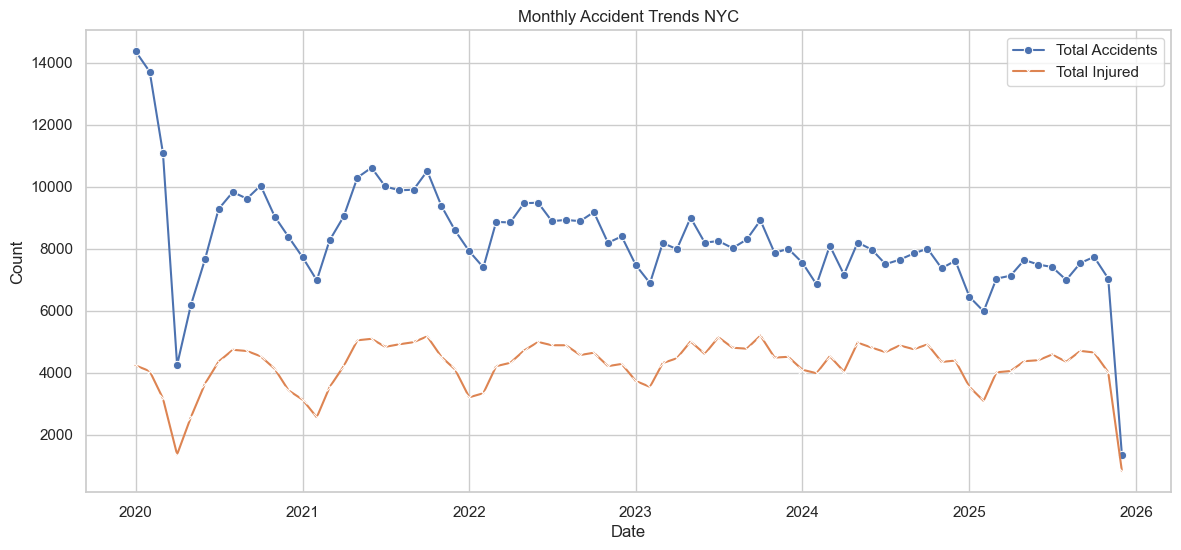

In [43]:
# DuckDB has powerful date functions like date_trunc
sql_trend = """
    SELECT 
        date_trunc('month', date) AS month_start,
        SUM(total_accidents) AS total_accidents,
        SUM(number_of_persons_injured) AS total_injured
    FROM gold_data
    GROUP BY month_start
    ORDER BY month_start
"""

df_trend = con.execute(sql_trend).fetchdf()

# Visualization
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_trend, x='month_start', y='total_accidents', marker='o', label='Total Accidents')
sns.lineplot(data=df_trend, x='month_start', y='total_injured', marker='x', label='Total Injured')

plt.title("Monthly Accident Trends NYC")
plt.ylabel("Count")
plt.xlabel("Date")
plt.show()

In [ ]:
sql_dangerous_holidays = """
    SELECT 
        holiday_name,
        AVG(total_accidents) as avg_accidents
    FROM gold_data
    WHERE holiday_name != 'Non-Holiday'
    GROUP BY holiday_name
    HAVING COUNT(*) > 1 -- Filter out one-off holidays
    ORDER BY avg_accidents DESC
    LIMIT 5
"""

df_top5 = con.execute(sql_dangerous_holidays).fetchdf()

print("🚨 TOP 5 MOST DANGEROUS HOLIDAYS IN NYC 🚨")
print(df_top5.to_markdown(index=False))

🚨 TOP 5 MOST DANGEROUS HOLIDAYS IN NYC 🚨
| holiday_name                         |   avg_accidents |
|:-------------------------------------|----------------:|
| Labour Day                           |         2.71477 |
| Lincoln's Birthday                   |         2.70875 |
| Juneteenth National Independence Day |         2.68774 |
| New Year's Day                       |         2.64928 |
| Truman Day                           |         2.56444 |


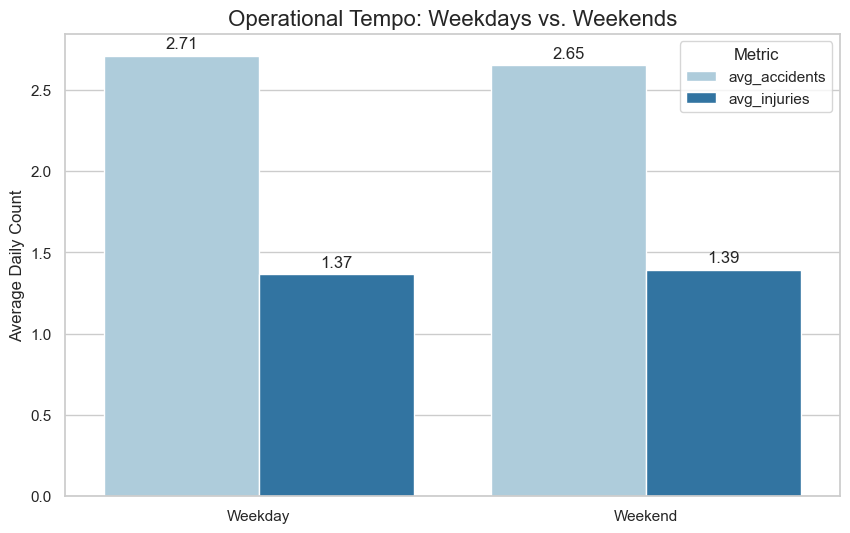

In [30]:
# 1. SQL Query
# We group by the boolean is_weekend flag
sql_weekend = """
    SELECT 
        CASE 
            WHEN is_weekend = true THEN 'Weekend' 
            ELSE 'Weekday' 
        END AS day_type,
        AVG(total_accidents) AS avg_accidents,
        AVG(number_of_persons_injured) AS avg_injuries,
        -- Calculate severity per day type
        SUM(number_of_persons_injured + number_of_persons_killed) / SUM(total_accidents) as severity_rate
    FROM gold_data
    GROUP BY day_type
"""

df_weekend = con.execute(sql_weekend).fetchdf()

# 2. Visualization (Grouped Bar Chart)
# We reshape the data to compare Accidents vs Injuries side-by-side
df_weekend_melt = df_weekend.melt(
    id_vars=['day_type'], 
    value_vars=['avg_accidents', 'avg_injuries'],
    var_name='Metric', 
    value_name='Count'
)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df_weekend_melt, 
    x='day_type', 
    y='Count', 
    hue='Metric', 
    palette='Paired',
    ax=ax
)

ax.set_title("Operational Tempo: Weekdays vs. Weekends", fontsize=16)
ax.set_ylabel("Average Daily Count")
ax.set_xlabel("")

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.show()

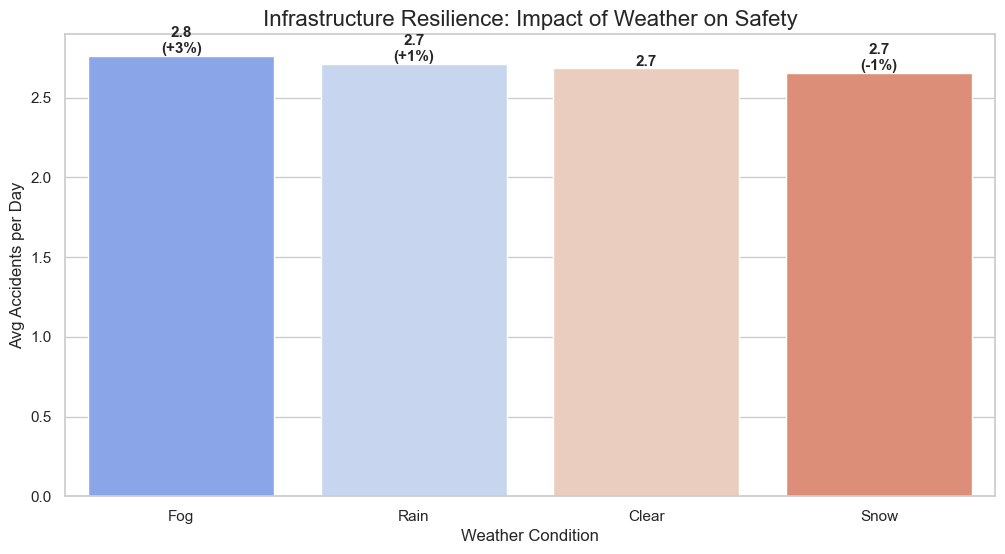

In [31]:
# 1. SQL Query
# We create a categorical 'Weather State' from the boolean flags.
# Priority: Snow > Rain > Fog > Clear (Hierarchical check)
sql_weather = """
    SELECT 
        CASE 
            WHEN has_snow = true THEN 'Snow' 
            WHEN has_rain = true THEN 'Rain' 
            WHEN is_foggy = true THEN 'Fog' 
            ELSE 'Clear' 
        END AS weather_condition,
        COUNT(*) as days_count,
        AVG(total_accidents) as avg_accidents,
        AVG(number_of_persons_injured) as avg_injuries
    FROM gold_data
    GROUP BY weather_condition
    -- We only want conditions that actually occurred in our data
    HAVING count(*) > 5 
    ORDER BY avg_accidents DESC
"""

df_weather = con.execute(sql_weather).fetchdf()

# 2. Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Accident Volume
sns.barplot(
    data=df_weather, 
    x='weather_condition', 
    y='avg_accidents', 
    hue='weather_condition',
    palette='coolwarm', 
    legend=False,
    dodge=False,
    ax=ax1
)

ax1.set_title("Infrastructure Resilience: Impact of Weather on Safety", fontsize=16)
ax1.set_ylabel("Avg Accidents per Day")
ax1.set_xlabel("Weather Condition")

# Add percentage comparison label (vs Clear days)
# We find the baseline (Clear) value first
baseline_accidents = df_weather.loc[df_weather['weather_condition'] == 'Clear', 'avg_accidents'].values[0]

for i, row in df_weather.iterrows():
    val = row['avg_accidents']
    # Calculate % difference from clear days
    pct_diff = ((val - baseline_accidents) / baseline_accidents) * 100
    
    label = f"{val:.1f}"
    if row['weather_condition'] != 'Clear':
        symbol = "+" if pct_diff > 0 else ""
        label += f"\n({symbol}{pct_diff:.0f}%)"
    
    ax1.text(i, val, label, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

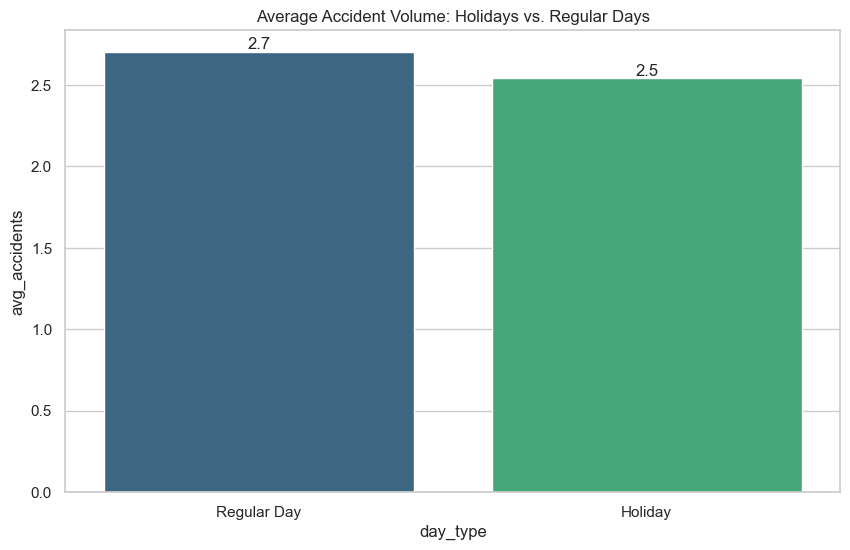

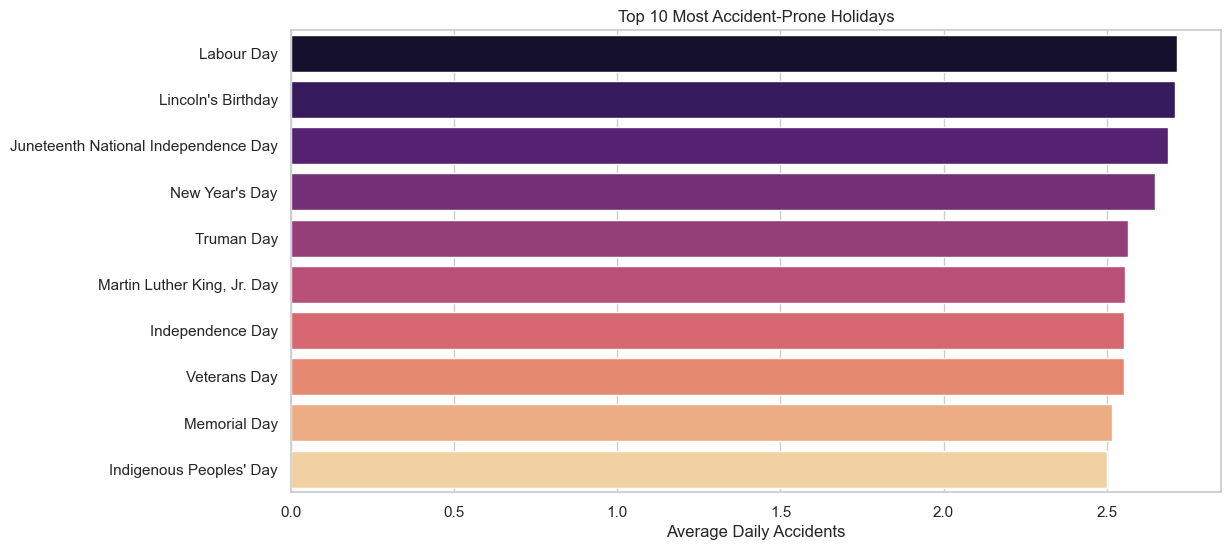

Impact Analysis:
                 impact_type  avg_accidents
0  High Impact (Public/Bank)       2.528230
1    Partial Impact (School)       2.564437
2    Low Impact (Observance)       2.604775


In [45]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Setup
sns.set_theme(style="whitegrid")
con = duckdb.connect()
# Create a view of your parquet file so we can query it like a SQL table
con.execute("CREATE OR REPLACE VIEW gold_data AS SELECT * FROM '../data/gold/daily_stats.parquet'")

# --- ANALYSIS 1: Holiday vs. Non-Holiday Baseline ---
# We compare the average daily accidents to see if holidays are truly safer.
sql_holiday_baseline = """
    SELECT 
        CASE 
            WHEN holiday_name != 'Non-Holiday' THEN 'Holiday' 
            ELSE 'Regular Day' 
        END AS day_type,
        AVG(total_accidents) as avg_accidents,
        AVG(number_of_persons_injured) as avg_injuries,
        -- Lethality: (Injured + Killed) / Total Accidents
        (SUM(number_of_persons_injured) + SUM(number_of_persons_killed)) / SUM(total_accidents) as severity_rate
    FROM gold_data
    GROUP BY day_type
"""
df_baseline = con.execute(sql_holiday_baseline).fetchdf()

# Visualization 1
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_baseline, x='day_type', y='avg_accidents', hue='day_type', palette='viridis', legend=False, ax=ax)
ax.set_title("Average Accident Volume: Holidays vs. Regular Days")
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')
plt.show()

# --- ANALYSIS 2: Ranking Most Dangerous Holidays ---
# We filter for only holidays to see which specific ones have the highest volume.
sql_holiday_rank = """
    SELECT 
        holiday_name,
        COUNT(*) as days_recorded,
        AVG(total_accidents) as avg_daily_accidents,
        AVG(number_of_persons_injured) as avg_daily_injuries
    FROM gold_data
    WHERE holiday_name != 'Non-Holiday'
    GROUP BY holiday_name
    HAVING days_recorded > 0
    ORDER BY avg_daily_accidents DESC
    LIMIT 10
"""
df_rank = con.execute(sql_holiday_rank).fetchdf()

# Visualization 2
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_rank, x='avg_daily_accidents', y='holiday_name', hue='holiday_name', palette='magma', legend=False, ax=ax)
ax.set_title("Top 10 Most Accident-Prone Holidays")
ax.set_xlabel("Average Daily Accidents")
ax.set_ylabel("")
plt.show()

# --- ANALYSIS 3: High Impact vs. Low Impact ---
# Does a "Bank Holiday" (High Impact) reduce traffic more than a "School Holiday" (Partial)?
sql_impact = """
    SELECT 
        CASE 
            WHEN high_impact_holiday THEN 'High Impact (Public/Bank)'
            WHEN partial_impact_holiday THEN 'Partial Impact (School)'
            WHEN low_impact_holiday THEN 'Low Impact (Observance)'
            ELSE 'No Impact'
        END as impact_type,
        AVG(total_accidents) as avg_accidents
    FROM gold_data
    WHERE holiday_name != 'Non-Holiday'
    GROUP BY impact_type
    ORDER BY avg_accidents ASC
"""
df_impact = con.execute(sql_impact).fetchdf()

print("Impact Analysis:")
print(df_impact)